<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Результаты-всех-моделей" data-toc-modified-id="Результаты-всех-моделей-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Результаты всех моделей</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Задача – построить модель с предельно большим значением *F1*-меры. Необходимо довести метрику до 0.59.

Дополнительно измерим метрику *AUC-ROC*, сравнив её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [53]:
df = pd.read_csv('/datasets/Churn.csv')

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [55]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [56]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

Приведём названия колонок к snake_case

In [57]:
df.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_crcard',
       'is_active_member', 'estimated_salary', 'exited']

Избавимся от колонок, не имеющих математического смысла для построения моделей

In [58]:
df.drop(['row_number', 'customer_id', 'surname'], axis=1, inplace=True)

Посмотрим на типы данных

In [59]:
df.dtypes

credit_score          int64
geography            object
gender               object
age                   int64
tenure              float64
balance             float64
num_of_products       int64
has_crcard            int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

Nan'ы в столбце `tenure` заполним медианой

In [60]:
df['tenure'].fillna(df['tenure'].mean(), inplace=True)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_crcard        10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Поскольку данные значения являются исключительно годами, есть смысл перевести тип ячеек в целочисленный


In [62]:
df.tenure = df.tenure.astype('int') 

Посмотрим на изменённый фрейм и перейдём к анализу баланса классов

In [63]:
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_crcard,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Исследование задачи

Выведем количественное соотношение классов целевого признака

0    0.7963
1    0.2037
Name: exited, dtype: float64

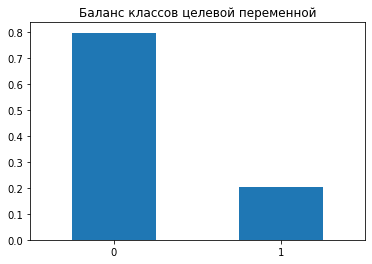

In [64]:
display(df['exited'].value_counts(normalize=True))
df['exited'].value_counts(normalize=True).plot(kind='bar', rot=0);
plt.title('Баланс классов целевой переменной');

Проведём OHE для категориальных переменных

In [65]:
df_ohe = pd.get_dummies(df, drop_first=True, columns=['geography'])
df_ohe = pd.get_dummies(df_ohe, drop_first=True, columns=['gender'])

In [66]:
df_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_crcard,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Разделим данные на предикторы и целевой признак


In [67]:
features = df_ohe.drop('exited', axis=1)
target = df_ohe['exited']

Поскольку в дальнейшем мы намерены использовать функцию `RandomizedSearchCV`, которая задействует кросс-валидацию,<br>
мы поделим выборку на трейн и тест без валидационной

In [68]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=1)

In [69]:
df_ohe.columns

Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_crcard', 'is_active_member', 'estimated_salary', 'exited',
       'geography_Germany', 'geography_Spain', 'gender_Male'],
      dtype='object')

In [70]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])

features_test[numeric] = scaler.transform(features_test[numeric])

Напишем функцию для расчёта AUC-ROC

In [71]:
def roc_plot(model):
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]

    auc_roc = roc_auc_score(target_test, probabilities_one_test)

    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

    plt.figure()

    plt.plot(fpr, tpr)

    # Для сравнения построим ROC-кривую случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.0]) 

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC-кривая")

    plt.show()
    
    return print('AUC-ROC модели:', auc_roc)

Обучим с поиском лучших гиперпараметров `Случайный лес`


f1 наилучшей модели: 0.5514106508292954


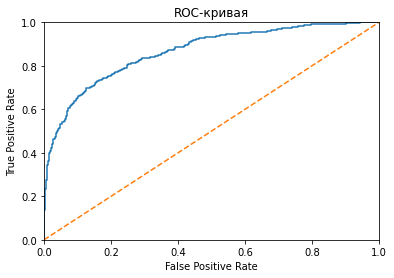

AUC-ROC модели: 0.8655662393162393


In [72]:
forest_model = RandomForestClassifier(random_state=1)

forest_param_grid = {'n_estimators': range (10, 61, 10),
              'max_depth': range (1, 21),
              'min_samples_leaf': range (1, 21),
              'min_samples_split': range (1, 21) }

forest_rs = RandomizedSearchCV(forest_model, forest_param_grid, scoring='f1')

forest_rs.fit(features_train, target_train)

print(f'f1 наилучшей модели: {forest_rs.best_score_}')

roc_plot(forest_rs.best_estimator_)

Обучим с поиском лучших гиперпараметров `Дерево решений`


f1 наилучшей модели: 0.5591258260070986


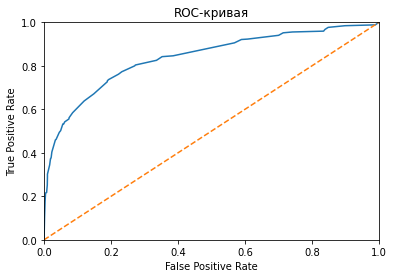

AUC-ROC модели: 0.8375582750582752


In [73]:
tree_model = DecisionTreeClassifier(random_state=1)

tree_param_grid = {'max_depth': range (1, 21)}

tree_rs = RandomizedSearchCV(tree_model, tree_param_grid, scoring='f1')

tree_rs.fit(features_train, target_train)

print(f'f1 наилучшей модели: {tree_rs.best_score_}')

roc_plot(tree_rs.best_estimator_)

Обучим с поиском лучших гиперпараметров `Логистическую регрессию`


f1 наилучшей модели: 0.3031836342559661


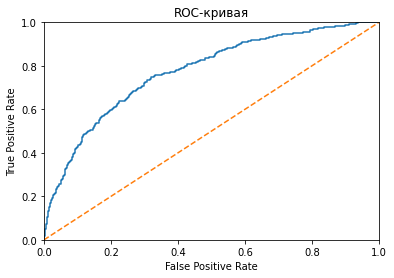

AUC-ROC модели: 0.7740394327894328


In [74]:
log_model = LogisticRegression(random_state=1)

log_param_grid = { 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                   'penalty':['none', 'elasticnet', 'l1', 'l2'],
                   'C':[0.001, 0.01, 0.1, 1, 10, 100] }

log_rs = RandomizedSearchCV(log_model, log_param_grid, scoring='f1')

log_rs.fit(features_train, target_train)

print(f'f1 наилучшей модели: {log_rs.best_score_}')

roc_plot(log_rs.best_estimator_)

Итого у нас получились три модели со следующими показателями *f1* и *AUC-ROC*:
- RandomForestClassifier: f1 ~ 0.55, AUC-ROC ~ 0.86
- DecisionTreeClassifier: f1 ~ 0.55, AUC-ROC ~ 0.84
- LogisticRegression:     f1 ~ 0.30, AUC-ROC ~ 0.77

Ни одной из представленных моделей мы не смогли превысить f1, равного 0.59. Возможно, восстановление баланса классов поможет нам решить проблему

## Борьба с дисбалансом

Восстановим баланс классов в выбранных нами моделях несколькими способами.<br>
- подберём подходящие *веса классов* <br>
- сделаем *upsampling* <br>
- воспользуемся функцией генерации семплов *SMOTE*

### Случайный лес

**Сбалансируем веса классов гиперпараметром** и выведем показатели *f1* и *AUC-ROC*

f1 наилучшей модели: 0.6187449514572884


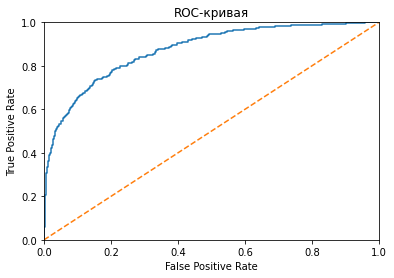

AUC-ROC модели: 0.8730001942501942


In [75]:
forest_balanced = RandomForestClassifier(random_state=1, class_weight='balanced')

forest_balanced_grid = {'n_estimators': range (10, 61, 10),
              'max_depth': range (1, 21),
              'min_samples_leaf': range (1, 21),
              'min_samples_split': range (1, 21)
              }

forest_balanced_rs = RandomizedSearchCV(forest_balanced, forest_balanced_grid, scoring='f1')

forest_balanced_rs.fit(features_train, target_train)

print(f'f1 наилучшей модели: {forest_balanced_rs.best_score_}')

roc_plot(forest_balanced_rs.best_estimator_)

Сделаем **upsampling** и выведем показатели *f1* и *auc-roc*


f1 наилучшей модели: 0.8579868254731011


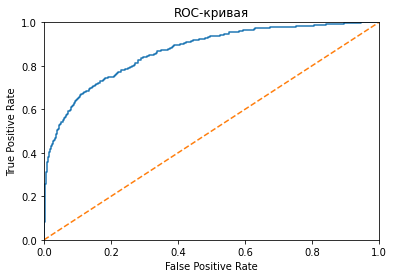

AUC-ROC модели: 0.8674339549339548


In [76]:
forest_balanced = RandomForestClassifier(random_state=1)

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(features_train, target_train, 4)


forest_balanced_grid = {'n_estimators': range (10, 61, 10),
              'max_depth': range (1, 21),
              'min_samples_leaf': range (1, 21),
              'min_samples_split': range (1, 21)
              }

forest_balanced_rs = RandomizedSearchCV(forest_balanced, forest_balanced_grid, scoring='f1')

forest_balanced_rs.fit(features_upsampled, target_upsampled)

print(f'f1 наилучшей модели: {forest_balanced_rs.best_score_}')

roc_plot(forest_balanced_rs.best_estimator_)

Проведём балансировку классов функцией **SMOTE**


In [77]:
features_train_smotes = features_train.copy()
target_train_smotes = target_train.copy()

smt = SMOTE(random_state=1234)
features_train_smote, target_train_smote = smt.fit_resample(features_train_smotes, target_train_smotes)

Проверим работу функции

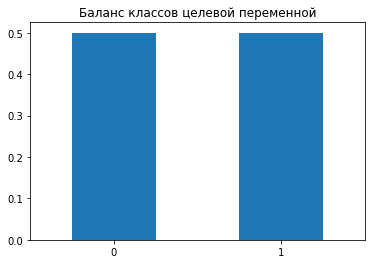

In [78]:
target_train_smote.value_counts(normalize=True)
target_train_smote.value_counts(normalize=True).plot(kind='bar', rot=0)
plt.title('Баланс классов целевой переменной');

Найдём лучший показатель *f1*, используя тот же `RandomizedSearchCV` и `смоут-выборки`


f1 наилучшей модели: 0.8563062084101368


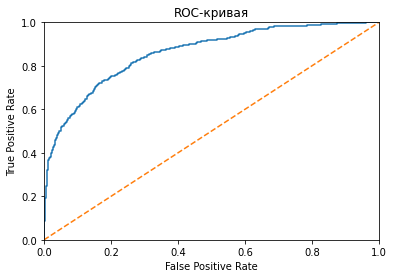

AUC-ROC модели: 0.8600893550893549


In [79]:
forest_balanced = RandomForestClassifier(random_state=1)

forest_balanced_grid = {'n_estimators': range (10, 61, 10),
              'max_depth': range (1, 21),
              'min_samples_leaf': range (1, 21),
              'min_samples_split': range (1, 21)
              }

forest_balanced_rs = RandomizedSearchCV(forest_balanced, forest_balanced_grid, scoring='f1')

forest_balanced_rs.fit(features_train_smote, target_train_smote)

print(f'f1 наилучшей модели: {forest_balanced_rs.best_score_}')

roc_plot(forest_balanced_rs.best_estimator_)

Результаты применения способов восстановления баланса классов в `Случайном лесе`:

- **class_weight**: f1 ~ 0.61, auc-roc ~ 0.87
- **upsampling**: f1 ~ 0.84, auc-roc ~ 0.87
- **SMOTE**: f1 ~ 0.87, auc-roc ~ 0.86

### Дерево решений

**Сбалансируем веса классов гиперпараметром** и выведем показатели *f1* и *AUC-ROC*

f1 наилучшей модели: 0.5711260810617932


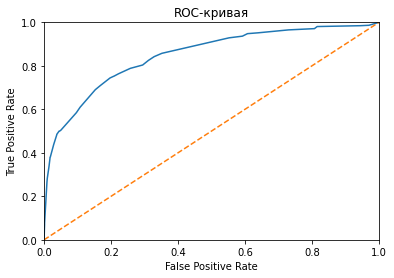

AUC-ROC модели: 0.847991452991453


In [80]:
tree_balanced = DecisionTreeClassifier(random_state=1, class_weight='balanced')

tree_param_grid = {'max_depth': range (1, 21)}
tree_balanced_rs = RandomizedSearchCV(tree_balanced, tree_param_grid, scoring='f1')
tree_balanced_rs.fit(features_train, target_train)

print(f'f1 наилучшей модели: {tree_balanced_rs.best_score_}')

roc_plot(tree_balanced_rs.best_estimator_)

Используем уже готовые методом **upsampling** данные и выведем показатели *f1* и *auc-roc*

f1 наилучшей модели: 0.9269579537789218


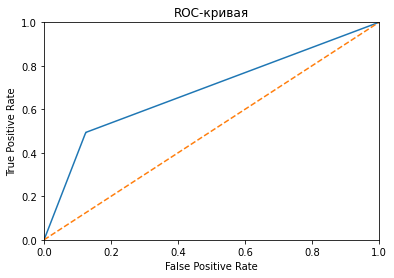

AUC-ROC модели: 0.6846416083916084


In [81]:
tree_balanced = DecisionTreeClassifier(random_state=1)

tree_param_grid = {'max_depth': range (1, 21)}
tree_balanced_rs = RandomizedSearchCV(tree_balanced, tree_param_grid, scoring='f1')
tree_balanced_rs.fit(features_upsampled, target_upsampled)

print(f'f1 наилучшей модели: {tree_balanced_rs.best_score_}')

roc_plot(tree_balanced_rs.best_estimator_)

Используем уже готовые методом **SMOTE** данные и выведем показатели *f1* и *auc-roc*

f1 наилучшей модели: 0.813949976142565


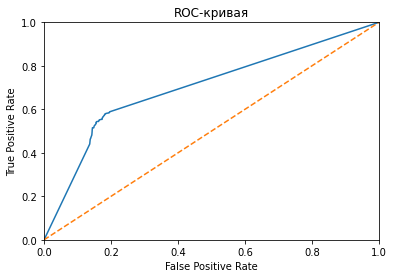

AUC-ROC модели: 0.7011790986790988


In [82]:
tree_balanced = DecisionTreeClassifier(random_state=1)

tree_param_grid = {'max_depth': range (1, 21)}
tree_balanced_rs = RandomizedSearchCV(tree_balanced, tree_param_grid, scoring='f1')
tree_balanced_rs.fit(features_train_smote, target_train_smote)

print(f'f1 наилучшей модели: {tree_balanced_rs.best_score_}')

roc_plot(tree_balanced_rs.best_estimator_)

Результаты применения способов восстановления баланса классов в `Дереве решений`:

- **class_weight**: f1 ~ 0.57, auc-roc ~ 0.84
- **upsampling**: f1 ~ 0.89, auc-roc ~ 0.70
- **SMOTE**: f1 ~ 0.81, auc-roc ~ 0.70

### Логистическая регрессия

**Сбалансируем веса классов гиперпараметром** и выведем показатели *f1* и *AUC-ROC*

f1 наилучшей модели: 0.48744746841182635


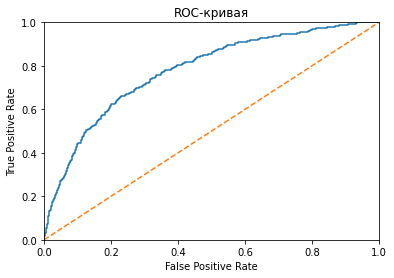

AUC-ROC модели: 0.7785062160062161


In [83]:
log_balanced = LogisticRegression(random_state=1, class_weight='balanced')

log_param_grid = { 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                   'penalty':['none', 'elasticnet', 'l1', 'l2'],
                   'C':[0.001, 0.01, 0.1, 1, 10, 100] }

log_balanced_rs = RandomizedSearchCV(log_balanced, log_param_grid, scoring='f1')

log_balanced_rs.fit(features_train, target_train)

print(f'f1 наилучшей модели: {log_balanced_rs.best_score_}')

roc_plot(log_balanced_rs.best_estimator_)

Используем уже готовые методом **upsampling** данные и выведем показатели *f1* и *auc-roc*

f1 наилучшей модели: 0.7042525960829282


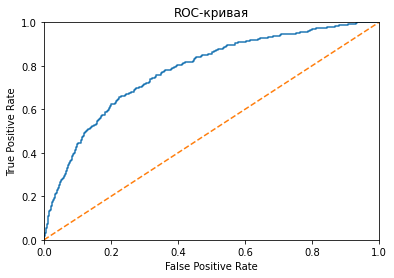

AUC-ROC модели: 0.7785275835275836


In [84]:
log_balanced = LogisticRegression(random_state=1)

log_param_grid = { 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                   'penalty':['none', 'elasticnet', 'l1', 'l2'],
                   'C':[0.001, 0.01, 0.1, 1, 10, 100] }

log_balanced_rs = RandomizedSearchCV(log_balanced, log_param_grid, scoring='f1')

log_balanced_rs.fit(features_upsampled, target_upsampled)

print(f'f1 наилучшей модели: {log_balanced_rs.best_score_}')

roc_plot(log_balanced_rs.best_estimator_)

Используем уже готовые методом **SMOTE** данные и выведем показатели *f1* и *auc-roc*

f1 наилучшей модели: 0.7224573450733784


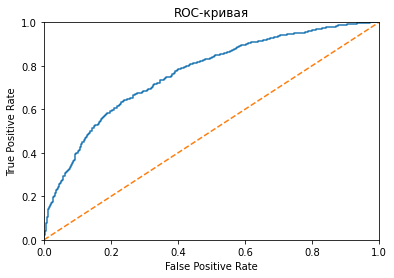

AUC-ROC модели: 0.7653311965811967


In [85]:
log_balanced = LogisticRegression(random_state=1)

log_param_grid = { 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                   'penalty':['none', 'elasticnet', 'l1', 'l2'],
                   'C':[0.001, 0.01, 0.1, 1, 10, 100] }

log_balanced_rs = RandomizedSearchCV(log_balanced, log_param_grid, scoring='f1')

log_balanced_rs.fit(features_train_smote, target_train_smote)

print(f'f1 наилучшей модели: {log_balanced_rs.best_score_}')

roc_plot(log_balanced_rs.best_estimator_)

Результаты применения способов восстановления баланса классов в `Логистической регрессии`:

- **class_weight**: f1 ~ 0.50, auc-roc ~ 0.78
- **upsampling**: f1 ~ 0.71, auc-roc ~ 0.78
- **SMOTE**: f1 ~ 0.72, auc-roc ~ 0.78

### Результаты всех моделей

`Случайный лес`:
- **class_weight**: f1 ~ 0.61, auc-roc ~ 0.87
- **upsampling**: f1 ~ 0.84, auc-roc ~ 0.87
- **SMOTE**: f1 ~ 0.87, auc-roc ~ 0.86

`Дерево решений`:
- **class_weight**: f1 ~ 0.57, auc-roc ~ 0.84
- **upsampling**: f1 ~ 0.89, auc-roc ~ 0.70
- **SMOTE**: f1 ~ 0.81, auc-roc ~ 0.70

`Логистическая регрессия`:
- **class_weight**: f1 ~ 0.50, auc-roc ~ 0.78
- **upsampling**: f1 ~ 0.71, auc-roc ~ 0.78
- **SMOTE**: f1 ~ 0.72, auc-roc ~ 0.78

Примечательной особенностью является увеличение **f1** после `upsampling` и `SMOTE` на всех моделях на **20-30** единиц, в отличие от `class_weight`, <br>
в то время как **auc-roc** сильно не изменяется: лишь в Дереве решений `upsampling` и `SMOTE` понижают метрику на **14** единиц по сравнению с `class_weight`

## Тестирование модели

Проэкзаменуем модели на тестовой выборке

In [86]:
# Дерево решений
best_tree = tree_balanced_rs.best_estimator_
tree_predicted = best_tree.predict(features_test)

# Проба для Дерева решений
probabilities_test = best_tree.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print('f1 Дерева решений на тестовой выборке:', f1_score(target_test, tree_predicted))
print('auc_roc Дерева решений на тестовой выборке:', roc_auc_score(target_test, probabilities_one_test))
print('---' *21)

# Логистическая регрессия
best_log = log_balanced_rs.best_estimator_
log_predicted = best_log.predict(features_test)

# Проба для Логистической регрессии
probabilities_test = best_log.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print('f1 Логрегрессии на тестовой выборке:', f1_score(target_test, log_predicted))
print('auc_roc Логрегрессии на тестовой выборке:', roc_auc_score(target_test, probabilities_one_test))
print('---' *21)

# Случайный лес
best_forest = forest_balanced_rs.best_estimator_
forest_predicted = best_forest.predict(features_test)

# Проба для Случайного леса
probabilities_test = best_forest.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print('f1 Случайного леса на тестовой выборке:', f1_score(target_test, forest_predicted))
print('auc_roc Случайного леса на тестовой выборке:', roc_auc_score(target_test, probabilities_one_test))

f1 Дерева решений на тестовой выборке: 0.5004344048653345
auc_roc Дерева решений на тестовой выборке: 0.7011790986790988
---------------------------------------------------------------
f1 Логрегрессии на тестовой выборке: 0.49888641425389757
auc_roc Логрегрессии на тестовой выборке: 0.7653311965811967
---------------------------------------------------------------
f1 Случайного леса на тестовой выборке: 0.6144256455921638
auc_roc Случайного леса на тестовой выборке: 0.8600893550893549


Предсказания моделей на тестовых выборках выявили явные недочёты в процессе обучения `Дерева решений` и `Логистической регрессии`, поскольку чересчур высокий показатель f1 резко снизился. Вероятно, проблема в переобучении. Наиболее стабильной же оказалась модель `Случайный лес`

## Вывод

В исходном сете о клиентах банка мы выполнили предобработку данных для машинного обучения. 
Были удалены не имеющие значения для предсказаний признаки фрейма, 
заполнены пропуски медианой, 
а также изменён тип данных признака `tenure`

В качестве моделей для предсказания данных мы выбрали 3 наиболее распространённых: 
- "Дерево решений", 
- Логистическую регрессию, 
- "Случайный лес".

Для каждой из этих моделей мы применили 3 способа борьбы с дисбалансом классов:
- class_weight
- upsampling
- SMOTE

Выполнив работу по балансировке классов данными методами, мы обучили модели и увидели подозрительно высокие результаты у некоторых из них. Тест выявил данную проблему. Результаты двух моделей упали, а наиболее устойчивым оказался "Случайный лес", f1 которого **(~0.60)** превысил указанный в задаче порог **(0.59)**